# Comparing Capitalism and Communism - how are they similar and how are they different?

Exploring the similarities and differences between the philosophical schools for capitalism and communism based on texts written by Adam Smith, David Ricardo, John Maynard Keynes, Karl Marx, and Vladimir Lenin. These texts are compiled in the *History of Philosophy* dataset on [Kaggle](https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy).

### Preliminary Data Exploration:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/philosophy_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360808 entries, 0 to 360807
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   title                      360808 non-null  object
 1   author                     360808 non-null  object
 2   school                     360808 non-null  object
 3   sentence_spacy             360808 non-null  object
 4   sentence_str               360808 non-null  object
 5   original_publication_date  360808 non-null  int64 
 6   corpus_edition_date        360808 non-null  int64 
 7   sentence_length            360808 non-null  int64 
 8   sentence_lowered           360808 non-null  object
 9   tokenized_txt              360808 non-null  object
 10  lemmatized_str             360808 non-null  object
dtypes: int64(3), object(8)
memory usage: 30.3+ MB


In [45]:
#df.head()

In [5]:
df[df.school=='capitalism'][['author','title']].drop_duplicates() #3 documents

author                                              title
307896    Smith                              The Wealth Of Nations
319589  Ricardo  On The Principles Of Political Economy And Tax...
322679   Keynes  A General Theory Of Employment, Interest, And ...

In [6]:
df[df.school=='communism'][['author','title']].drop_duplicates() #3 documents

author                     title
289938   Marx                   Capital
302934   Marx   The Communist Manifesto
303427  Lenin  Essential Works Of Lenin

### Exploratory Plots:

Exploratory boxplots to show the distributions of sentence_length for capitalism and communism. They are quite similar in appearance with the IQRs of both distributions entirely below 250 tokens. There are a few very long sentences in both schools (>500 tokens).

Specifically amongst the capitalism authors, Keynes has the tightest distribution of sentence length. Otherwise their distributions appear similar. As for Marx vs Lenin, Marx has a slightly lower IQR than Lenin.

In [8]:
#subset df for just capitalism and communism
mod_df = df[(df.school=='capitalism') | (df.school == 'communism')]
docs = mod_df[['title','tokenized_txt']].groupby('title').agg(lambda x: ''.join(list(x)))

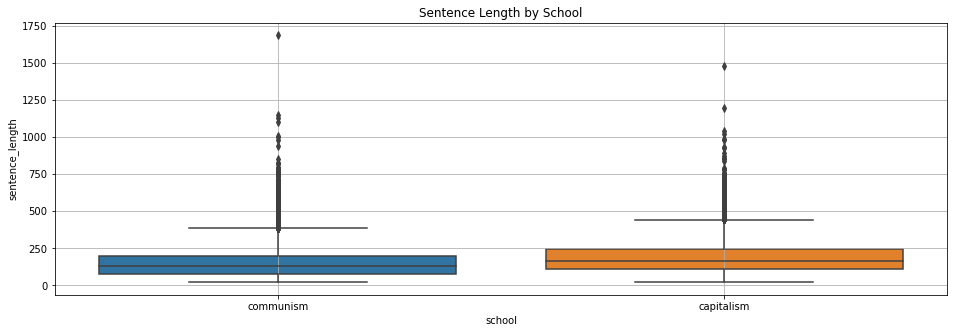

In [9]:
plt.figure(figsize=(16,5))
sns.boxplot(x='school', y='sentence_length', data=mod_df)
plt.title('Sentence Length by School')
plt.grid()

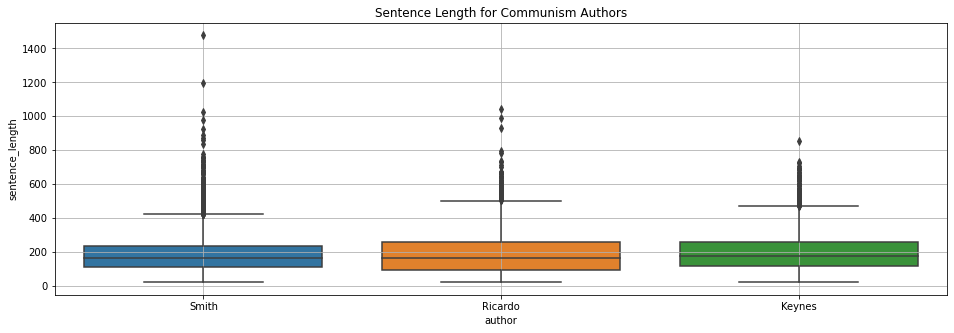

In [11]:
plt.figure(figsize=(16,5))
sns.boxplot(x='author', y='sentence_length', data=df[df.school=='capitalism'])
plt.title('Sentence Length for Communism Authors')
plt.grid()

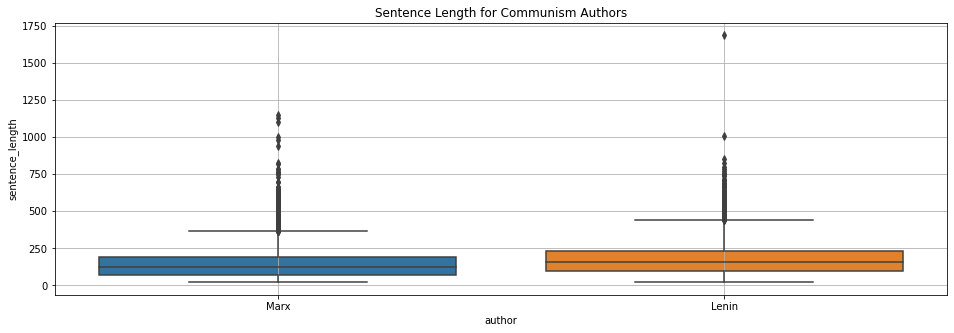

In [10]:
plt.figure(figsize=(16,5))
sns.boxplot(x='author', y='sentence_length', data=df[df.school=='communism'])
plt.title('Sentence Length for Communism Authors')
plt.grid()

### Data Preprocessing:

In [12]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def processStrings(token_string):
    return re.sub(r'[\'\[\]]', '', token_string).split(', ')

def processTokens(token_text):
    flat_df = token_text.to_numpy().flatten()
    joined_df = ', '.join(flat_df)
    
    filtered_sentence = []
    word_tokens = processStrings(joined_df)
    
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

def getWordCounts(filtered_sentence):
    return pd.Series(filtered_sentence).value_counts()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#remove non-alphabetical characters from tokens
text_tokens = [[re.sub('[^a-zA-Z]+', '', text) for text in doc.split()] for doc in mod_df.tokenized_txt]

In [39]:
#update and remove stopwords
filtered_tokens = text_tokens
stop_words.update(['would','therefore','may','must','much','however','also','perhaps','towards','likely','partly'
                   'said','say','upon','could','become','whilst','sometimes','though','sense','seem','hitherto','might',
                  'moreover','except','ie'])

def remove_stopwords(texts):
    return [[word for word in doc
             if word not in stop_words] for doc in texts]

filtered_tokens = remove_stopwords(filtered_tokens)

### Exploratory Analysis:

Top ten words used by frequency in capitalism and communism tokenized texts. Visually one can see many shared words (eg 'labour','one','value','capital',etc). Evidently all the top words appear somewhere in both texts (with >400 occurencances). The most commonly used word in capitalism texts that is not used in the communism texts is 'marginal'. For communism the most used word not used in capitalism is 'bourgeois'.

In [41]:
#Top 10 words by frequency in the tokenized text for capitalism
processed_cap = processTokens(df[df.school=='capitalism'].tokenized_txt)
capitalism_wcounts = getWordCounts(processed_cap)
cap_df = capitalism_wcounts.to_frame().reset_index()
cap_df.columns=['Word','Frequency']
cap_df[0:10]

Word  Frequency
0     price       2328
1     money       1906
2    labour       1786
3     value       1767
4     great       1758
5   capital       1648
6      part       1597
7   country       1597
8       one       1571
9  quantity       1514

In [42]:
#Top 10 words by frequency in the tokenized text for communism
processed_com = processTokens(df[df.school=='communism'].tokenized_txt)
communism_wcounts = getWordCounts(processed_com)
com_df = communism_wcounts.to_frame().reset_index()
com_df.columns=['Word','Frequency']
com_df[0:10]

Word  Frequency
0      labour       3311
1       value       2508
2         one       1771
3     capital       1547
4  production       1453
5       power       1095
6        time       1050
7        work       1027
8        form        926
9     working        914

In [43]:
all_tokens = df[(df.school=='capitalism') | (df.school == 'communism')].tokenized_txt
all_processed = processTokens(all_tokens)

#remove all words occuring fewer than 2 times
com_df = com_df[com_df.Frequency>1]

#remove all words occuring fewer than 2 times
cap_df = cap_df[cap_df.Frequency>1]

In [44]:
#find high frequency different words in capitalism and NOT communism tokenized text
diff_words = set(cap_df.Word).difference(set(com_df.Word))
diff_cap = pd.DataFrame(columns=["Word","Frequency"])
for word in diff_words:
    diff_cap = pd.concat([diff_cap,cap_df[cap_df['Word']==word]])
    
diff_cap.sort_values('Frequency',ascending=False)[0:10]

Word Frequency
118       marginal       340
320     propensity       162
387          taxed       137
452      liquidity       118
461    expectation       117
605  encouragement        91
634         levied        84
646    prospective        83
673           user        80
694           malt        77

In [19]:
#find high frequency different words in communism and NOT capitalism tokenized text
diff_words = set(com_df.Word).difference(set(cap_df.Word))
diff_com = pd.DataFrame(columns=["Word","Frequency"])
for word in diff_words:
    diff_com = pd.concat([diff_com,com_df[com_df['Word']==word]])
    
diff_com.sort_values('Frequency',ascending=False)[0:10]

Word Frequency
50      bourgeois       391
77          labor       326
97    proletariat       275
131     democracy       242
159  organization       211
162   bourgeoisie       209
180   imperialism       194
217        engels       170
225    democratic       163
232     factories       161

In [20]:
#find highest frequency words shared between capitalism and communism tokenized text sorted by frequency
#in capitalism
shared_words = set(cap_df.Word).intersection(set(com_df.Word))
shared_cap = pd.DataFrame(columns=["Word","Frequency"])
for word in shared_words:
    shared_cap = pd.concat([shared_cap,cap_df[cap_df['Word']==word]])
    
shared_cap.sort_values('Frequency',ascending=False)[0:10]

Word Frequency
0     price      2328
1     money      1906
2    labour      1786
3     value      1767
4     great      1758
5   capital      1648
6      part      1597
7   country      1597
8       one      1571
9  quantity      1514

In [21]:
#find highest frequency words shared between capitalism and communism tokenized text sorted by frequency
#in communism
shared_words = set(com_df.Word).intersection(set(cap_df.Word))
shared_com = pd.DataFrame(columns=["Word","Frequency"])
for word in shared_words:
    shared_com = pd.concat([shared_com,com_df[com_df['Word']==word]])
    
shared_com.sort_values('Frequency',ascending=False)[0:10]

Word Frequency
0      labour      3311
1       value      2508
2         one      1771
3     capital      1547
4  production      1453
5       power      1095
6        time      1050
7        work      1027
8        form       926
9     working       914

### Latent Diralect Allocation (LDA) Analysis:

In [33]:
#building dictionary and corpus for LDA
import gensim
from gensim import corpora
from gensim.corpora import Dictionary

dict_LoS = corpora.Dictionary(filtered_tokens)
dict_LoS.filter_extremes(no_below=20, no_above=0.5)
# print(dict_LoS)
# print(dict_LoS.token2id)

corpus = [dict_LoS.doc2bow(doc, allow_update=True) for doc in filtered_tokens]

LDA topic modelling results show how the different topics are connected.

In [35]:
from pprint import pprint
num_topics = 10
#id2word = dict_LoS.id2token
lda_model = gensim.models.LdaModel(corpus=corpus,id2word=dict_LoS,num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"economic" + 0.020*"aggregate" + 0.012*"conditions" + '
  '0.012*"production" + 0.010*"theory" + 0.008*"change" + 0.008*"influence" + '
  '0.008*"commonly" + 0.008*"maintain" + 0.008*"forces"'),
 (1,
  '0.017*"efficiency" + 0.011*"industry" + 0.011*"level" + 0.010*"trade" + '
  '0.009*"state" + 0.009*"country" + 0.008*"system" + 0.008*"exercise" + '
  '0.008*"motive" + 0.007*"landlord"'),
 (2,
  '0.024*"growth" + 0.021*"raised" + 0.019*"farmer" + 0.018*"said" + '
  '0.016*"obtain" + 0.015*"terms" + 0.015*"struggle" + 0.015*"return" + '
  '0.015*"large" + 0.014*"allow"'),
 (3,
  '0.021*"employment" + 0.017*"paid" + 0.015*"duties" + 0.015*"government" + '
  '0.014*"england" + 0.012*"argument" + 0.011*"trade" + 0.011*"lower" + '
  '0.010*"state" + 0.010*"century"'),
 (4,
  '0.070*"interest" + 0.036*"investment" + 0.028*"capital" + 0.023*"consume" + '
  '0.022*"consumption" + 0.018*"stock" + 0.015*"part" + 0.011*"propensity" + '
  '0.010*"people" + 0.009*"necessarily"'),
 (5,

In [36]:
top_topics = lda_model.top_topics(corpus)

In [37]:
from nltk import ngrams, FreqDist
all_counts = dict()
for size in 2, 3, 4, 5:
    all_counts[size] = FreqDist(ngrams(df[df.school=='capitalism'].tokenized_txt, size))


### WordClouds:

Word clouds representing capitalism and communism.

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))

In [ ]:
for schl in schools:
    df_temp = mod_df[mod_df.school==schl]
    print('School = ', schl.upper(), ':')
    
    text = " ".join(txt for txt in df_temp.sentence_lowered)
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate(text)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

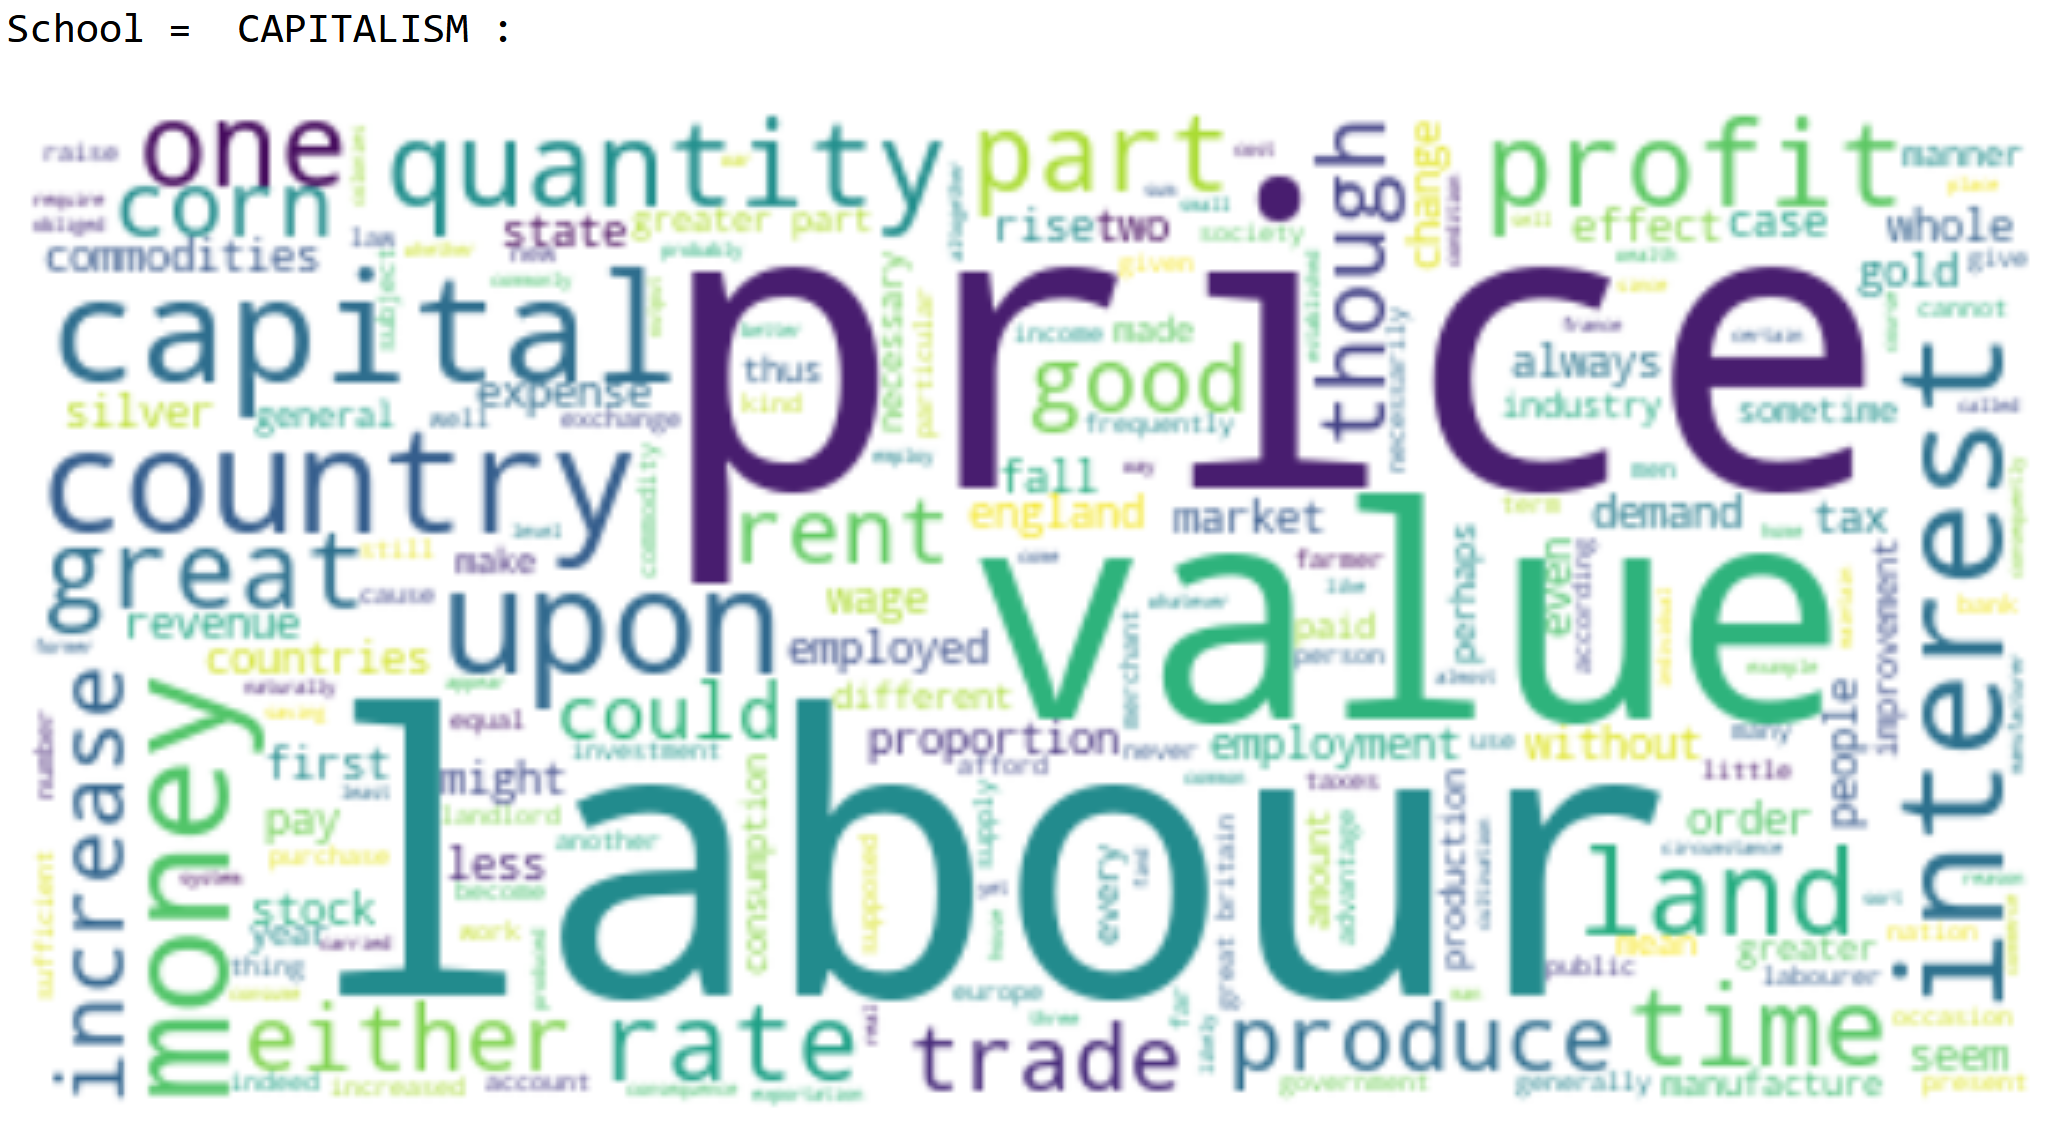

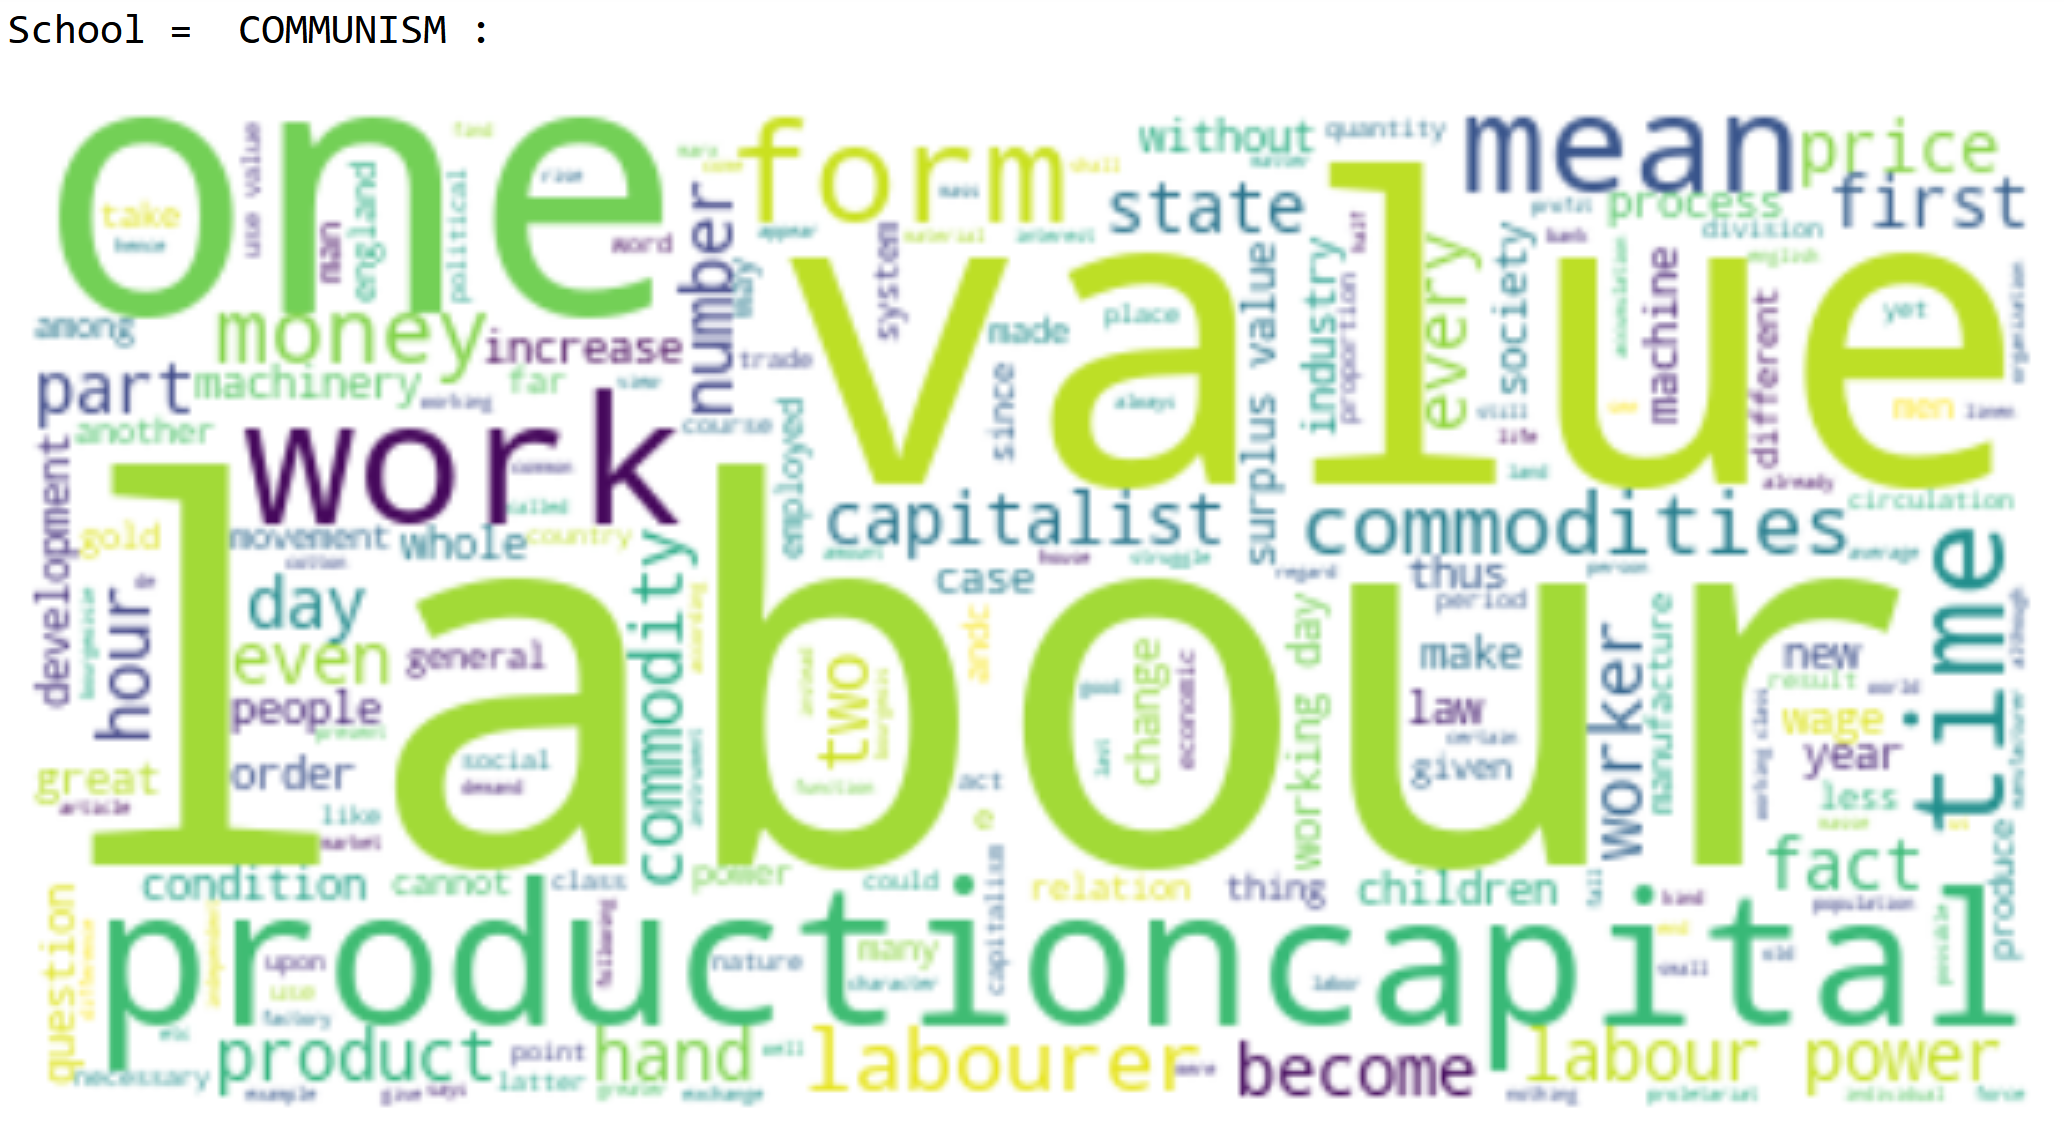

### Sentiment Analysis:

In [25]:
#Sentiment analysis functions
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sentimentAnalysis(sentence):
    siAnalyzer = SentimentIntensityAnalyzer() 
    sentDict = siAnalyzer.polarity_scores(sentence)
    
    if sentDict['compound'] >= 0.05:
        return "positive"
    elif sentDict['compound'] <= -0.05 :
        return "negative"
    else:
        return "neutral"

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
def analysis(dataframe,author):
    df = dataframe[dataframe['author'] == author] 
    corpus = ''
    nPos = 0
    nNeg = 0
    nNeutral = 0
    
    for token in df['sentence_lowered']:
        corpus += token
    
    for i in range (len(df)):
        sentiment = (sentimentAnalysis(df['sentence_lowered'].iloc[i]))
        if sentiment == "positive":
            nPos += 1
        elif sentiment == "negative":
            nNeg += 1
        else:
            nNeutral += 1
    
    plt.figure(figsize = (7, 7))
    plt.pie([nPos, nNeg, nNeutral], labels = ['Positive', 'Negative', 'Neutral'], autopct='%1.2f%%')
    plt.title('Sentiment Analysis for ' + author)

Sentiment analysis of the three different capitalism authors reveals similar sentiment distributions using this +-0.05 compound score threshold. 

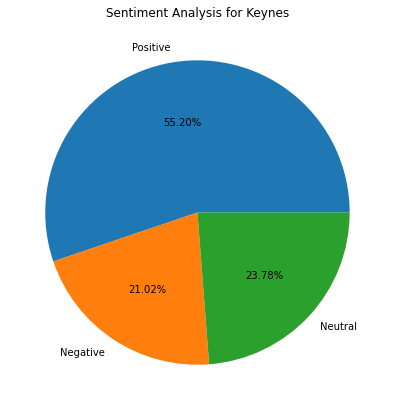

In [28]:
analysis(df,"Keynes")

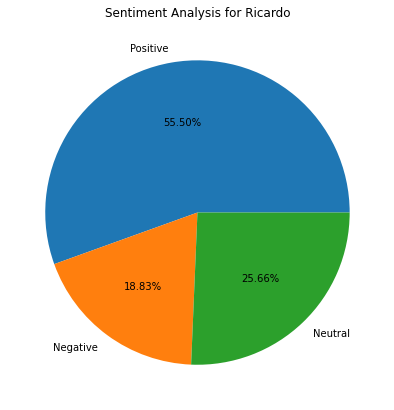

In [29]:
analysis(df,"Ricardo")

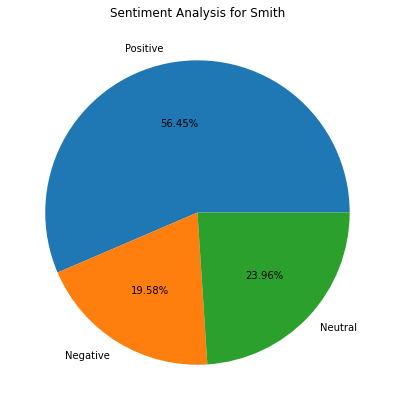

In [30]:
analysis(df,"Smith")

Sentiment analysis of Marx and Lenin reveals a more significant difference. While they use similar perentage of "positive" sentiment words, Lenin uses ~10% fewer neutral words and ~12% more negative words (in absolute terms) relative to Marx. This indicates Marx may have used more critical language when describing capitalism.

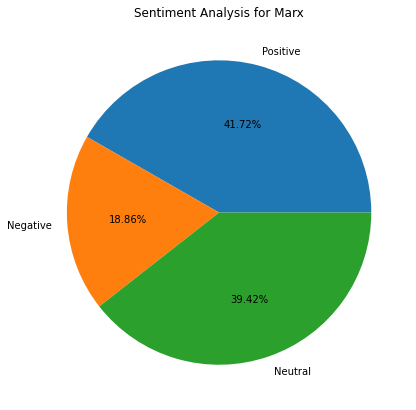

In [31]:
analysis(df,"Marx")

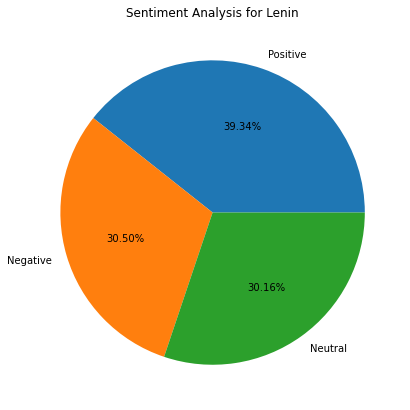

In [32]:
analysis(df,"Lenin")